## Homework Assignment for Graduate Course in Healthcare Analytics
- Using DE-SynPUF files downloaded from https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF.html
- Assignment: use methods related to decision trees to predict depression as response/target

In [1]:
# import and read file, use NaN for elements with no values
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 

df = pd.read_csv("combined_ben_sum_AddYear.csv", na_values = ['no info', '.'])
#print(df.head(5))

In [2]:
df.shape
print(df.columns)

Index(['Year', 'DESYNPUF_ID', 'BENE_BIRTH_DT', 'BENE_DEATH_DT',
       'BENE_SEX_IDENT_CD', 'BENE_RACE_CD', 'BENE_ESRD_IND', 'SP_STATE_CODE',
       'BENE_COUNTY_CD', 'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS',
       'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM', 'SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
       'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
       'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'],
      dtype='object')


In [3]:
#subset of data needed to answer assignment question #4
newdf = df[['DESYNPUF_ID','Year','BENE_BIRTH_DT','BENE_SEX_IDENT_CD','BENE_RACE_CD',
            'BENE_ESRD_IND','SP_STATE_CODE','BENE_COUNTY_CD','SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD','SP_DEPRESSN',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA']]
#print(newdf.head(5))

In [4]:
newdf.shape

(6873274, 19)

# Data Transformation

In [5]:
# checking to see how many duplicate rows, all columns except year
# don't want to skew results if have same patient over 2008-2010 with same conditions repeated each year
# only want to include if patient has developed new conditions
dup_df = newdf[newdf.duplicated(['DESYNPUF_ID','BENE_BIRTH_DT','BENE_SEX_IDENT_CD','BENE_RACE_CD',
                'BENE_ESRD_IND','SP_STATE_CODE','BENE_COUNTY_CD','SP_ALZHDMTA',
                'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD','SP_DEPRESSN',
                'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA']) == True].sort_values(by='DESYNPUF_ID')

In [6]:
#display(dup_df)
dup_df.shape

(1424410, 19)

In [7]:
# removing duplicate rows, 1424410 removed
df_no_dup_records_1 = newdf.drop_duplicates(['DESYNPUF_ID','BENE_BIRTH_DT','BENE_SEX_IDENT_CD','BENE_RACE_CD',
            'BENE_ESRD_IND','SP_STATE_CODE','BENE_COUNTY_CD','SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD','SP_DEPRESSN',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA'], keep='first')

In [8]:
df_no_dup_records_1.shape

(5448864, 19)

In [9]:
# also remove all recorcds after patient's first diagnosis, any future conditions post-depression diagnosis would not be a 
# predictor or cause of depression
df_no_dup_records = df_no_dup_records_1.drop_duplicates(['DESYNPUF_ID','BENE_BIRTH_DT','SP_DEPRESSN'], keep='first')

In [10]:
#  2,291,711‬ rows removed
df_no_dup_records.shape

(3157153, 19)

In [11]:
#calculate age (year column - year from BENE_BIRTH_DT)
#newdf["Birth_Year"] = pd.to_datetime(newdf['BENE_BIRTH_DT']).dt.year
df_no_dup_records.loc[:,'Age'] = df_no_dup_records.loc[:,'Year'] - (pd.to_datetime(newdf.loc[:,'BENE_BIRTH_DT'],format='%Y%m%d').dt.year)

C:\Users\barba\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\barba\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
#display and check age calculation working as expected
display(df_no_dup_records.head(5))

,DESYNPUF_ID,Year,BENE_BIRTH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,Age
0,00013D2EFD8E45D1,2008,19230501,1,1,0,26,950,2,2,2,2,2,2,2,2,2,2,2,85.0
1,00016F745862898F,2008,19430101,1,1,0,39,230,2,2,2,2,2,2,2,2,2,2,2,65.0
2,0001FDD721E223DC,2008,19360901,2,1,0,39,280,2,2,2,2,2,2,2,2,2,2,2,72.0
3,00021CA6FF03E670,2008,19410601,1,5,0,6,290,2,2,2,2,2,2,2,2,2,2,2,67.0
4,00024B3D2352D2D0,2008,19360801,1,1,0,52,590,2,2,2,2,2,2,2,2,1,2,2,72.0


In [13]:
# checking for any patients with multiple recods in one year (should only have one patient summary per year)
df_dup_record_year = df_no_dup_records[df_no_dup_records.duplicated(['DESYNPUF_ID','Year']) == True].sort_values(by='DESYNPUF_ID')

In [14]:
df_dup_record_year.shape
# returned 0 rows so we don't have any rows with duplicate patient ID and year

(0, 20)

In [15]:
print(df_no_dup_records.columns)

Index(['DESYNPUF_ID', 'Year', 'BENE_BIRTH_DT', 'BENE_SEX_IDENT_CD',
       'BENE_RACE_CD', 'BENE_ESRD_IND', 'SP_STATE_CODE', 'BENE_COUNTY_CD',
       'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD',
       'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA',
       'SP_STRKETIA', 'Age'],
      dtype='object')


In [16]:
# for each of the chronic condition col, prev data was 2 = no and 1 = yes
# replace 2 with 0 so have 0 = no and 1 = yes
for column in range(8,19):
    df_no_dup_records.iloc[:,column] = df_no_dup_records.iloc[:,column].replace(2,0)
    
# for BENE_ESRD_IND replace 'Y' with 1, 'N' is already set to 0
df_no_dup_records.loc[:,'BENE_ESRD_IND'] = df_no_dup_records.loc[:,'BENE_ESRD_IND'].replace('Y',1)

# enocde race column
df_no_dup_records.loc[:,'BENE_RACE_CD'] = df_no_dup_records.loc[:,'BENE_RACE_CD'].replace({1:'White',2:'Black',3:'Other', 5:'Hispanic'}).apply(str)
#Binary Encoding Catergorical Variables without Order
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=['BENE_RACE_CD'])
df_no_dup_records = encoder.fit_transform(df_no_dup_records)

# set sex to male = 0 and female = 1
df_no_dup_records.loc[:,'BENE_SEX_IDENT_CD'] = df_no_dup_records.loc[:,'BENE_SEX_IDENT_CD'].replace({1:0,2:1})

In [17]:
# verifying values look good
display(df_no_dup_records.head(5))

,DESYNPUF_ID,Year,BENE_BIRTH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD_0,BENE_RACE_CD_1,BENE_RACE_CD_2,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,...,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,Age
0,00013D2EFD8E45D1,2008,19230501,0,0,0,1,0,26,950,...,0,0,0,0,0,0,0,0,0,85.0
1,00016F745862898F,2008,19430101,0,0,0,1,0,39,230,...,0,0,0,0,0,0,0,0,0,65.0
2,0001FDD721E223DC,2008,19360901,1,0,0,1,0,39,280,...,0,0,0,0,0,0,0,0,0,72.0
3,00021CA6FF03E670,2008,19410601,0,0,1,0,0,6,290,...,0,0,0,0,0,0,0,0,0,67.0
4,00024B3D2352D2D0,2008,19360801,0,0,0,1,0,52,590,...,0,0,0,0,0,0,1,0,0,72.0


# Random Forest Model with Imbalanced Classes

In [40]:
X = df_no_dup_records.loc[:,['BENE_SEX_IDENT_CD',
       'BENE_RACE_CD_0', 'BENE_RACE_CD_1', 'BENE_RACE_CD_2', 'BENE_ESRD_IND','SP_ALZHDMTA', 'SP_CHF',
       'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DIABETES',
       'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA', 'Age']].values
y = df_no_dup_records.loc[:,'SP_DEPRESSN'].values

#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=0)

In [41]:
# Try random forest model
from sklearn.ensemble import RandomForestClassifier
classifierObj = RandomForestClassifier(n_estimators=10, criterion='gini', bootstrap=False)
classifierObj.fit(X_train,y_train)
#grid_param= {  
#    'n_estimators': [5, 10, 15],
#    'criterion': ['gini', 'entropy'],
#    'bootstrap': [True, False]
#}
#from sklearn.model_selection import GridSearchCV
#gd_sr= GridSearchCV(estimator=classifierObj, param_grid=grid_param, scoring='accuracy', cv=5, n_jobs=-1)
#gd_sr.fit(X_train, y_train) 
#print(gd_sr.best_params_) 
#print(gd_sr.best_score_)
# grid search results {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 10} score: 0.682652136395948

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
#K-Fold Cross Validation
#from sklearn.model_selection import cross_val_score
#modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
#print(modelAccuracies.mean())
#print(modelAccuracies.std())

0.7012308094783315
0.0006170364367741137


In [43]:
#Making predictions on the Test Set
y_pred= classifierObj.predict(X_test)

#Evaluating the predictions using a Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[589477  71113]
 [212105  74451]]


In [44]:
from sklearn.metrics import recall_score, precision_score
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print('recall: {0:0.2f}'.format(recall))
print('precision: {0:0.2f}'.format(precision))

recall: 0.26
precision: 0.51


RandomForest: f1=0.345 auc=0.471


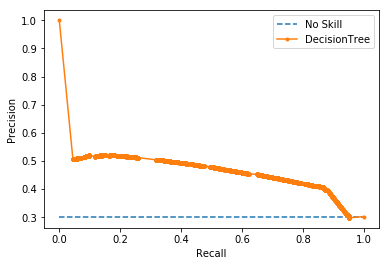

In [52]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# predict probabilities
lr_probs = classifierObj.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = classifierObj.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('RandomForest: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='DecisionTree')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Random Forest with Balanced Classes

In [20]:
# Class count
count_class_0, count_class_1 = df_no_dup_records.SP_DEPRESSN.value_counts()

# Divide by class
df_class_0 = df_no_dup_records[df_no_dup_records['SP_DEPRESSN'] == 0]
df_class_1 = df_no_dup_records[df_no_dup_records['SP_DEPRESSN'] == 1]

Random under-sampling:
1    954304
0    954304
Name: SP_DEPRESSN, dtype: int64


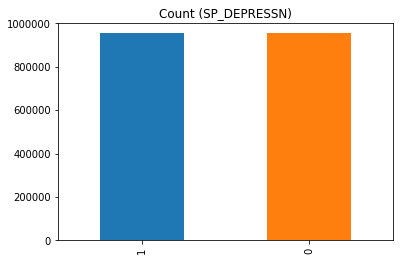

In [21]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.SP_DEPRESSN.value_counts())

df_test_under.SP_DEPRESSN.value_counts().plot(kind='bar', title='Count (SP_DEPRESSN)');

In [22]:
print(df_test_under.columns)
print(df_test_under.shape)

Index(['DESYNPUF_ID', 'Year', 'BENE_BIRTH_DT', 'BENE_SEX_IDENT_CD',
       'BENE_RACE_CD_0', 'BENE_RACE_CD_1', 'BENE_RACE_CD_2', 'BENE_ESRD_IND',
       'SP_STATE_CODE', 'BENE_COUNTY_CD', 'SP_ALZHDMTA', 'SP_CHF',
       'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES',
       'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA', 'Age'],
      dtype='object')
(1908608, 22)


In [23]:
# split data into train/test
X_bal = df_test_under.loc[:,['BENE_SEX_IDENT_CD',
       'BENE_RACE_CD_0', 'BENE_RACE_CD_1', 'BENE_RACE_CD_2', 'BENE_ESRD_IND','SP_ALZHDMTA', 'SP_CHF',
       'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DIABETES',
       'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA', 'Age']].values
y_bal = df_test_under.loc[:,'SP_DEPRESSN'].values

#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_bal,y_bal,test_size=0.3,random_state=0)

In [32]:
# Try random forest model
from sklearn.ensemble import RandomForestClassifier
classifierObj2 = RandomForestClassifier(n_estimators=10, criterion='gini', bootstrap=False)
classifierObj2.fit(X_train,y_train)
#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj2, X=X_train, y=y_train, cv=10)
print(modelAccuracies.mean())
print(modelAccuracies.std())

0.6541554278014178
0.001261397116829543


Confusion matrix:
 [[177013 109239]
 [ 88464 197867]]


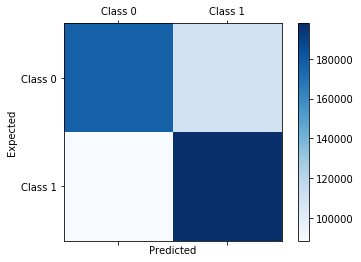

In [30]:
#Making predictions on the Test Set
y_pred= classifierObj2.predict(X_test)

#Evaluating the predictions using a Confusion Matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [28]:
from sklearn.metrics import recall_score, precision_score
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print('recall: {0:0.2f}'.format(recall))
print('precision: {0:0.2f}'.format(precision))

recall: 0.69
precision: 0.64


RandomForest: f1=0.667 auc=0.673


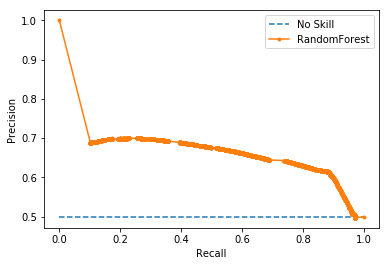

In [33]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# predict probabilities
lr_probs = classifierObj2.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = classifierObj2.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('RandomForest: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='RandomForest')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()